In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
from torchvision.models import SqueezeNet1_1_Weights, ShuffleNet_V2_X0_5_Weights, MobileNet_V3_Small_Weights, EfficientNet_V2_S_Weights
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import glob
import torchmetrics
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, AUROC
from sklearn.model_selection import StratifiedKFold
from pytorchcv.model_provider import get_model as ptcv_get_model

import medmnist
from medmnist import INFO, Evaluator

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
def get_transforms():
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    data_transforms = {
          'train':transforms.Compose([
              transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'test':transforms.Compose([
              transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
    return data_transforms

In [34]:
def freeze_all_but_fc(model):
  """
  Freezes the parameters of all layers except the fc layer in a ShuffleNetV2 model.

  Args:
      model: A ShuffleNetV2 model instance.

  Returns:
      The modified ShuffleNetV2 model.
  """
  for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
      param.requires_grad = False
  return model


In [39]:
def preTrainImageNet(model_name, dataset_name):
    info = INFO[dataset_name]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    
    DataClass = getattr(medmnist, info['python_class'])
    class_labels = info['label']
    print(info['label'])
    
    data_transforms = get_transforms()
    
    BATCH_SIZE = 128
    
    sets = ['train','test']
    image_datasets = {x:DataClass(split=x, transform=data_transforms[x], download=True, size=128)
                    for x in ['train','test']}

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'],batch_size=BATCH_SIZE,
                                                shuffle=True,num_workers=0),
                   'test': torch.utils.data.DataLoader(image_datasets['test'],batch_size=2*BATCH_SIZE,
                                                shuffle=True,num_workers=0)
                  }
    
    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','test']}
    
    
    # pretrained_model_ImageNet = models.squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT)
    # pretrained_model_ImageNet = ptcv_get_model('sqnxt23_w1', pretrained=True)
    # pretrained_model_ImageNet = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.DEFAULT)
    # pretrained_model_ImageNet = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
    # pretrained_model_ImageNet = models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
    pretrained_model_ImageNet = torch.hub.load("coderx7/simplenet_pytorch:v1.0.0", "simplenetv1_small_m2_05", pretrained=True)
    
    #freezing previous layers
    for param in pretrained_model_ImageNet.features.parameters():
        param.requires_grad = False
    # pretrained_model_ImageNet = freeze_all_but_fc(pretrained_model_ImageNet)
    
    if model_name == 'squeezenet':
        # Newly created modules have require_grad=True by default
        num_features = pretrained_model_ImageNet.classifier[1].in_channels
        features = list(pretrained_model_ImageNet.classifier.children())[:-3] # Remove last 3 layers
        features.extend([nn.Conv2d(num_features, n_classes, kernel_size=1)]) # Add
        features.extend([nn.ReLU(inplace=True)]) # Add
        features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
        pretrained_model_ImageNet.classifier = nn.Sequential(*features)
    elif model_name == 'squeezenext':
        num_features = pretrained_model_ImageNet.output.in_features
        pretrained_model_ImageNet.output = nn.Linear(num_features, n_classes)
    elif model_name == 'shufflenet':
        num_features = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(in_features=num_features, out_features=n_classes)
    elif model_name == 'mobilenetv3small':
        num_features = pretrained_model_ImageNet.classifier[3].in_features
        pretrained_model_ImageNet.classifier[3] = nn.Linear(in_features=num_features, out_features=n_classes)
    elif model_name == 'efficientnet':
        num_features = pretrained_model_ImageNet.classifier[1].in_features
        pretrained_model_ImageNet.classifier[1] = nn.Linear(num_features, n_classes)
    elif model_name == 'simplenet':
        num_features = pretrained_model_ImageNet.classifier.in_features
        pretrained_model_ImageNet.classifier = nn.Linear(num_features, n_classes)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")
    
    pretrained_model_ImageNet.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.01)
    
    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    
    model_ft, metrics = train_model(pretrained_model_ImageNet, dataset_name, criterion, optimizer, step_lr_scheduler, 
                                    dataloaders, dataset_sizes, n_classes, num_epochs=10)

In [40]:
def train_model(model, dataset_name, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, num_classes, num_epochs=25):
    since = time.time()
    torch.cuda.reset_peak_memory_stats(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_,preds = torch.max(outputs,1)
                    #loss = criterion(outputs,labels)
                    #googlenetcprfix
                    if str(type(outputs)) == "<class 'torch.Tensor'>":
                        _,preds = torch.max(outputs,1)
                        labels = labels.squeeze().long()
                        loss = criterion(outputs,labels)
                    else :
                        _,preds = torch.max(outputs.logits,1)
                        loss = criterion(outputs.logits,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'test':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=num_classes)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=num_classes)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=num_classes)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calcutate AUCOR
    # auroc = AUROC(task="multiclass", num_classes=num_classes)
    # auroc(predicted_labels, ground_truth_labels)
    # print(f'AUROC: {auroc.compute():.4f}')
    
    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=num_classes, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt_dir = './plots'
    
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(plt_dir+'/accuracy_curves/'+ f'fold_{fold_num}.png')

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(plt_dir+'/loss_curves/'+ f'fold_{fold_num}.png')

    metrics = {}
    metrics['accuracy'] = accuracy.compute()
    metrics['precision'] = precision.compute()
    metrics['recall'] = recall.compute()
    metrics['f1'] = f1.compute()
    # metrics['auroc'] = auroc.comupte()
    metrics['time'] = time_elapsed
    # metrics['memory'] = torch.cuda.max_memory_allocated()/(1024*1024)


    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


In [41]:
def print_metrics(metrics):
  #total_time = metrics["time"]*5
  print(f'Average accuracy: {metrics["accuracy"]:.4f}')
  print(f'Average precision: {metrics["precision"]:.4f}')
  print(f'Average recall: {metrics["recall"]:.4f}')
  print(f'Average F1 score: {metrics["f1"]:.4f}')
  print(f'Average Time elapsed: {metrics["time"]:.4f} seconds')
  print(f'Memory Usage: {metrics["memory"]:.4f} MiB')

## BreastMNIST (128x128)

{'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
saving in checkpoint_path:tmp/simplenetv1_small_m2_05-ca4b3e2b.pth
Epoch 0/9
----------


Using cache found in /home/anas/.cache/torch/hub/coderx7_simplenet_pytorch_v1.0.0


train Loss: 2.5055 Acc: 0.6190
test Loss: 0.6726 Acc: 0.7372

Epoch 1/9
----------
train Loss: 8.5284 Acc: 0.6117
test Loss: 5.1492 Acc: 0.2692

Epoch 2/9
----------
train Loss: 4.5116 Acc: 0.6099
test Loss: 10.0233 Acc: 0.7308

Epoch 3/9
----------
train Loss: 9.5249 Acc: 0.6319
test Loss: 3.3312 Acc: 0.7308

Epoch 4/9
----------
train Loss: 11.3356 Acc: 0.5989
test Loss: 3.3114 Acc: 0.2821

Epoch 5/9
----------
train Loss: 10.6440 Acc: 0.6117
test Loss: 2.2507 Acc: 0.4038

Epoch 6/9
----------
train Loss: 2.9458 Acc: 0.5769
test Loss: 6.0812 Acc: 0.7308

Epoch 7/9
----------
train Loss: 4.4662 Acc: 0.7308
test Loss: 4.1955 Acc: 0.7308

Epoch 8/9
----------
train Loss: 4.5581 Acc: 0.7289
test Loss: 2.0409 Acc: 0.7436

Epoch 9/9
----------
train Loss: 1.3533 Acc: 0.7399
test Loss: 0.9960 Acc: 0.7564

Training complete in 0m 12s
Best val Acc: 0.756410
Accuracy: 0.6242
Precision: 0.5170
Recall: 0.5166
F1: 0.5167
Confusion Matrix: 
tensor([[ 145,  366],
        [ 348, 1041]])


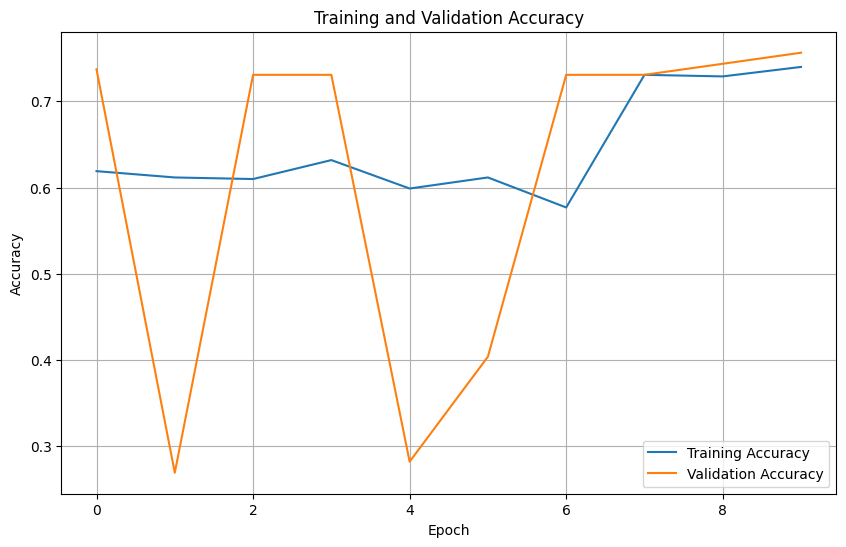

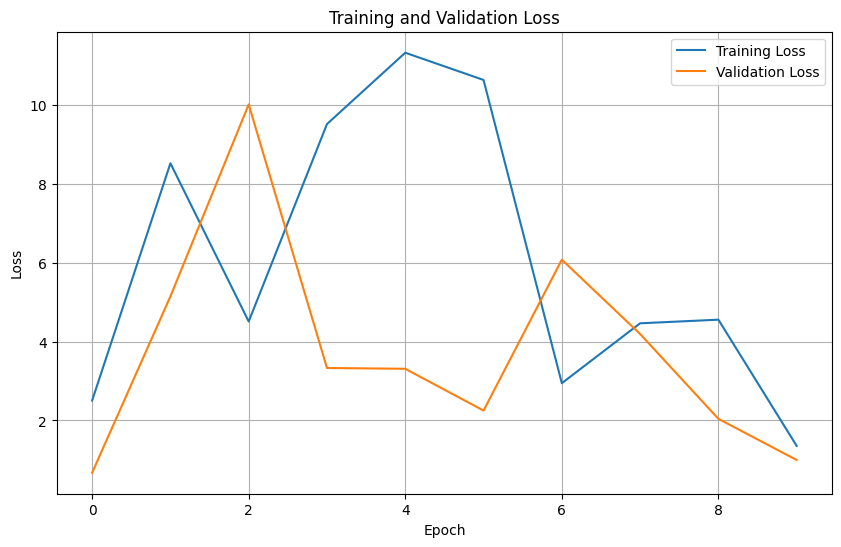

In [42]:
preTrainImageNet("simplenet", 'breastmnist')

{'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Epoch 0/9
----------
train Loss: 0.6633 Acc: 0.6355
test Loss: 0.6604 Acc: 0.5769

Epoch 1/9
----------
train Loss: 0.6141 Acc: 0.7143
test Loss: 0.6345 Acc: 0.6410

Epoch 2/9
----------
train Loss: 0.5951 Acc: 0.7161
test Loss: 0.5815 Acc: 0.7115

Epoch 3/9
----------
train Loss: 0.6028 Acc: 0.7344
test Loss: 0.5699 Acc: 0.7244

Epoch 4/9
----------
train Loss: 0.5910 Acc: 0.7234
test Loss: 0.5719 Acc: 0.7372

Epoch 5/9
----------
train Loss: 0.6136 Acc: 0.6978
test Loss: 0.5739 Acc: 0.7372

Epoch 6/9
----------
train Loss: 0.5836 Acc: 0.7289
test Loss: 0.5746 Acc: 0.7372

Epoch 7/9
----------
train Loss: 0.5891 Acc: 0.7308
test Loss: 0.5727 Acc: 0.7308

Epoch 8/9
----------
train Loss: 0.5960 Acc: 0.7198
test Loss: 0.5715 Acc: 0.7244

Epoch 9/9
----------
train Loss: 0.5847 Acc: 0.7143
test 

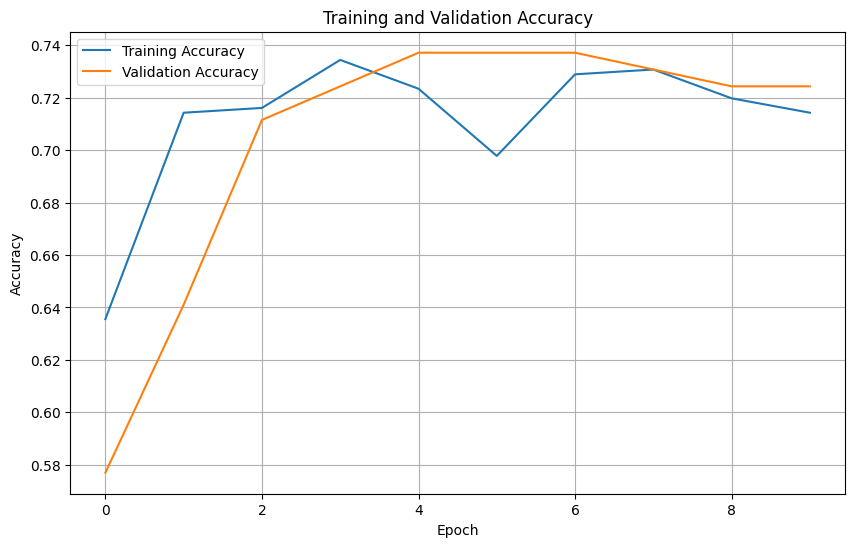

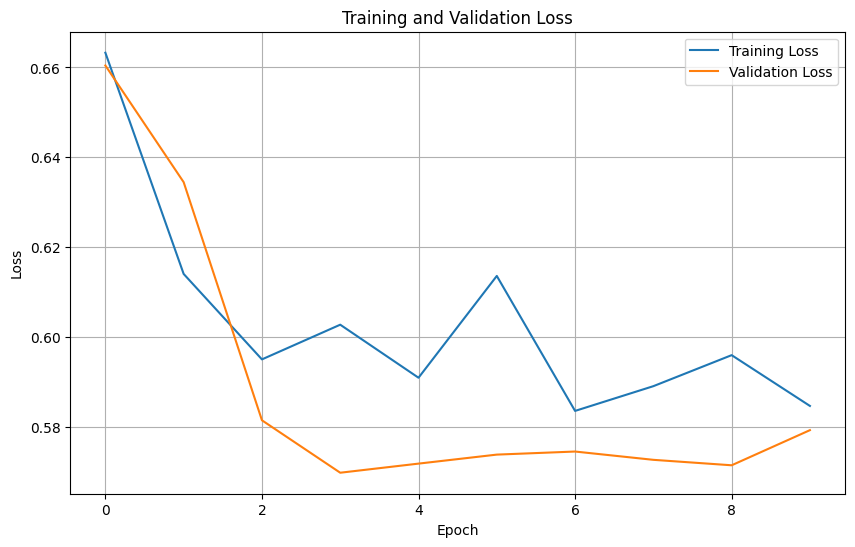

In [38]:
preTrainImageNet("efficientnet", 'breastmnist')

{'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Epoch 0/9
----------
train Loss: 0.6738 Acc: 0.5751
test Loss: 0.5680 Acc: 0.7308

Epoch 1/9
----------
train Loss: 0.6293 Acc: 0.6777
test Loss: 0.5675 Acc: 0.7308

Epoch 2/9
----------
train Loss: 0.5900 Acc: 0.7344
test Loss: 0.5661 Acc: 0.7308

Epoch 3/9
----------
train Loss: 0.5943 Acc: 0.7015
test Loss: 0.5647 Acc: 0.7308

Epoch 4/9
----------
train Loss: 0.5588 Acc: 0.7454
test Loss: 0.5628 Acc: 0.7308

Epoch 5/9
----------
train Loss: 0.5679 Acc: 0.7399
test Loss: 0.5608 Acc: 0.7308

Epoch 6/9
----------
train Loss: 0.5602 Acc: 0.7546
test Loss: 0.5601 Acc: 0.7308

Epoch 7/9
----------
train Loss: 0.5452 Acc: 0.7418
test Loss: 0.5593 Acc: 0.7308

Epoch 8/9
----------
train Loss: 0.5530 Acc: 0.7363
test Loss: 0.5578 Acc: 0.7308

Epoch 9/9
----------
train Loss: 0.5392 Acc: 0.7564
test 

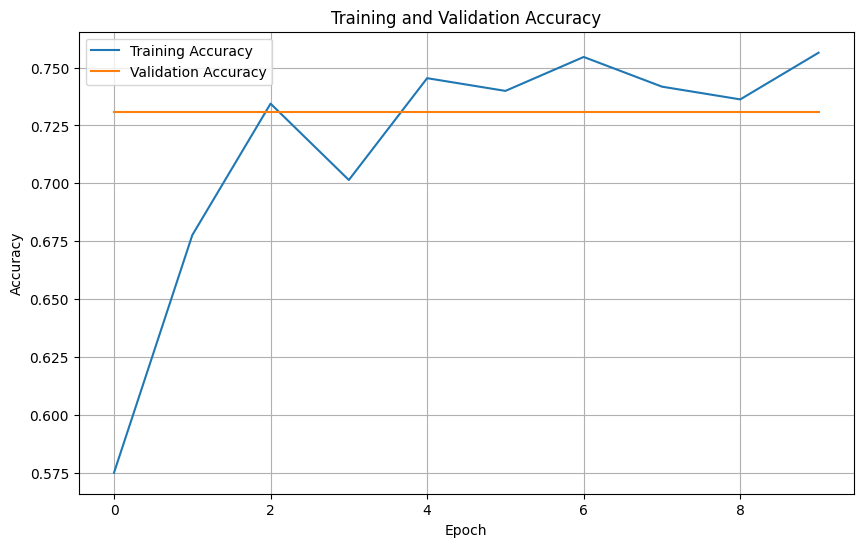

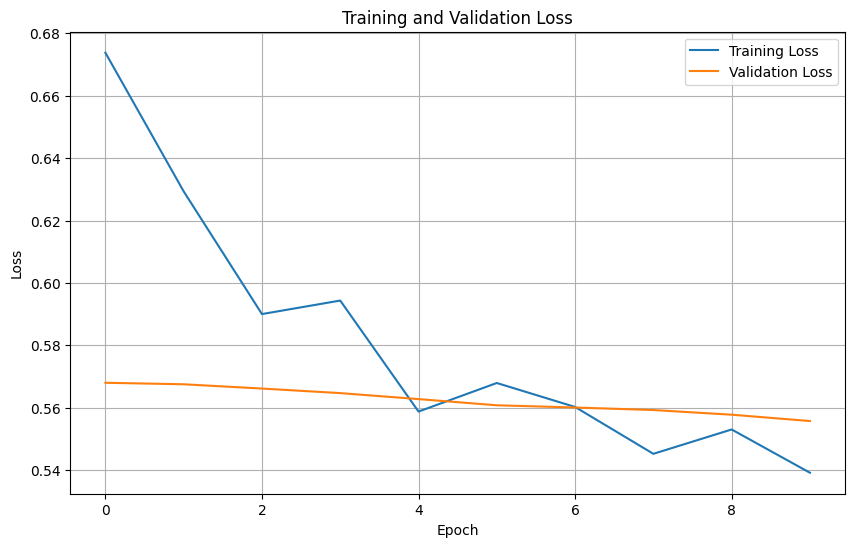

In [30]:
preTrainImageNet("mobilenetv3small", 'breastmnist')

{'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Epoch 0/9
----------
train Loss: 0.6868 Acc: 0.7125
test Loss: 0.6815 Acc: 0.7308

Epoch 1/9
----------
train Loss: 0.6800 Acc: 0.7308
test Loss: 0.6735 Acc: 0.7308

Epoch 2/9
----------
train Loss: 0.6734 Acc: 0.7308
test Loss: 0.6665 Acc: 0.7308

Epoch 3/9
----------
train Loss: 0.6674 Acc: 0.7308
test Loss: 0.6606 Acc: 0.7308

Epoch 4/9
----------
train Loss: 0.6619 Acc: 0.7308
test Loss: 0.6558 Acc: 0.7308

Epoch 5/9
----------
train Loss: 0.6569 Acc: 0.7308
test Loss: 0.6517 Acc: 0.7308

Epoch 6/9
----------
train Loss: 0.6526 Acc: 0.7308
test Loss: 0.6475 Acc: 0.7308

Epoch 7/9
----------
train Loss: 0.6495 Acc: 0.7308
test Loss: 0.6475 Acc: 0.7308

Epoch 8/9
----------
train Loss: 0.6484 Acc: 0.7308
test Loss: 0.6477 Acc: 0.7308

Epoch 9/9
----------
train Loss: 0.6482 Acc: 0.73

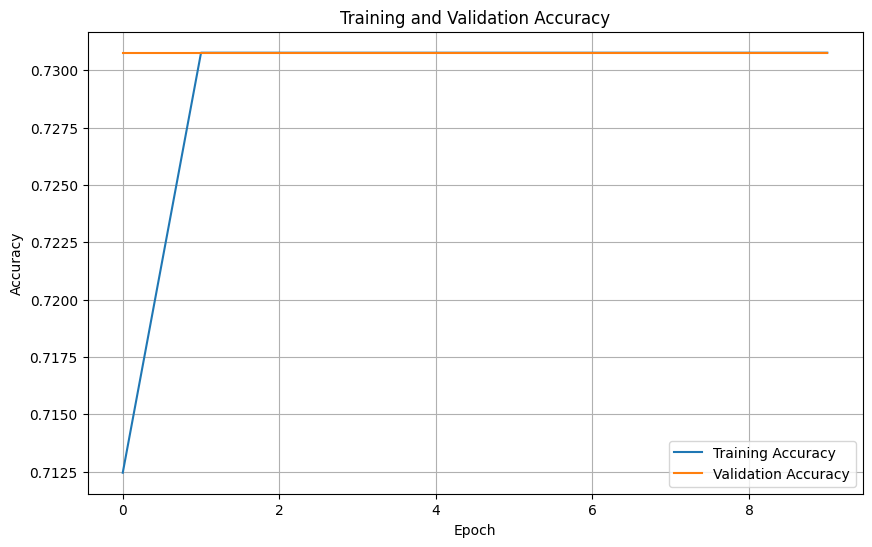

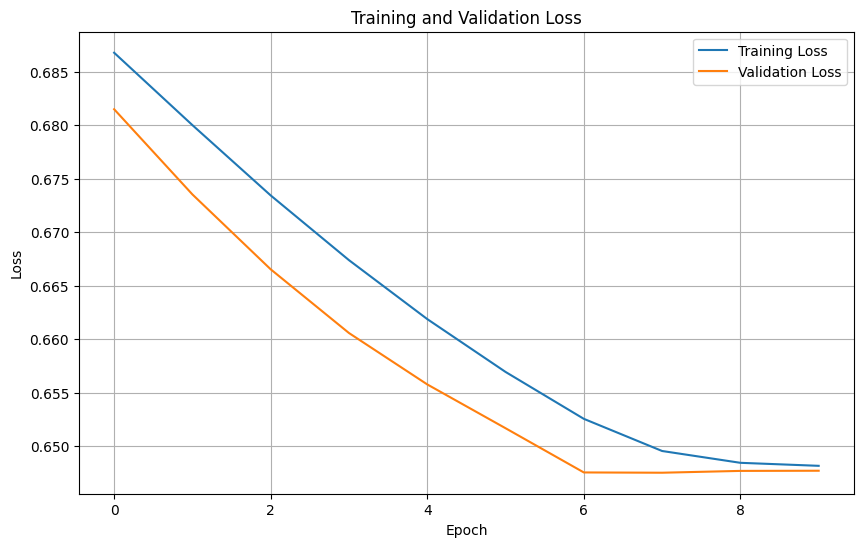

In [9]:
preTrainImageNet("shufflenet", 'breastmnist')

{'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Epoch 0/9
----------
train Loss: 0.7982 Acc: 0.6209
test Loss: 0.6272 Acc: 0.7115

Epoch 1/9
----------
train Loss: 0.5877 Acc: 0.7070
test Loss: 0.6235 Acc: 0.6667

Epoch 2/9
----------
train Loss: 0.5713 Acc: 0.7179
test Loss: 0.6023 Acc: 0.7372

Epoch 3/9
----------
train Loss: 0.5450 Acc: 0.7271
test Loss: 0.6172 Acc: 0.7372

Epoch 4/9
----------
train Loss: 0.5757 Acc: 0.7198
test Loss: 0.6485 Acc: 0.6410

Epoch 5/9
----------
train Loss: 0.5888 Acc: 0.7143
test Loss: 0.6286 Acc: 0.7051

Epoch 6/9
----------
train Loss: 0.5503 Acc: 0.7418
test Loss: 0.6156 Acc: 0.7179

Epoch 7/9
----------
train Loss: 0.5766 Acc: 0.7381
test Loss: 0.5926 Acc: 0.7051

Epoch 8/9
----------
train Loss: 0.5392 Acc: 0.7326
test Loss: 0.5679 Acc: 0.7308

Epoch 9/9
----------
train Loss: 0.5417 Acc: 0.74

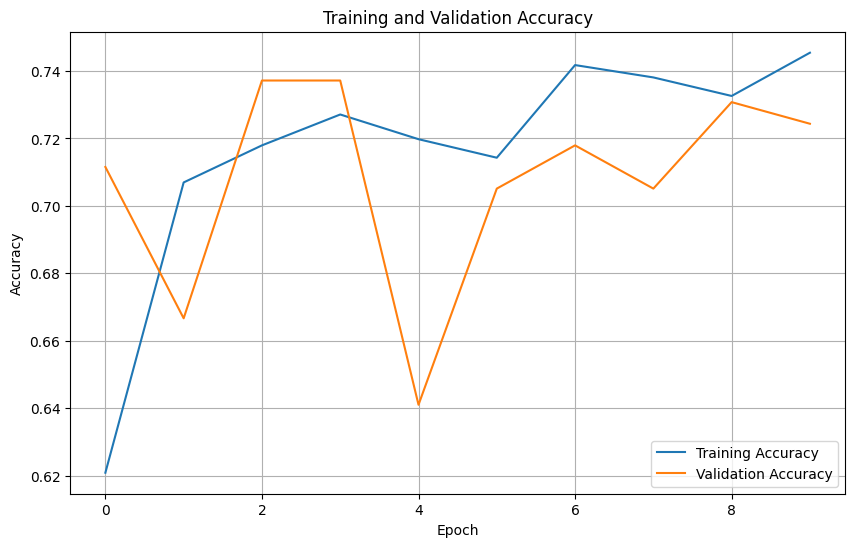

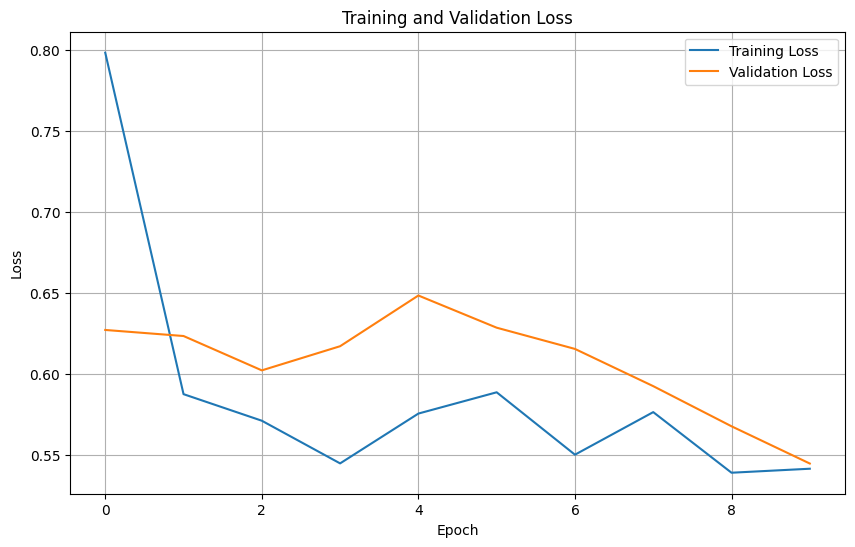

In [8]:
preTrainImageNet("squeezenext", 'breastmnist')

{'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Using downloaded and verified file: /home/anas/.medmnist/breastmnist_128.npz
Epoch 0/24
----------
train Loss: 0.6561 Acc: 0.6300
test Loss: 0.5895 Acc: 0.7308

Epoch 1/24
----------
train Loss: 0.5613 Acc: 0.7308
test Loss: 0.5034 Acc: 0.7692

Epoch 2/24
----------
train Loss: 0.5205 Acc: 0.7582
test Loss: 0.5010 Acc: 0.8141

Epoch 3/24
----------
train Loss: 0.5153 Acc: 0.7674
test Loss: 0.4670 Acc: 0.8205

Epoch 4/24
----------
train Loss: 0.5051 Acc: 0.7766
test Loss: 0.4490 Acc: 0.8333

Epoch 5/24
----------
train Loss: 0.4976 Acc: 0.7784
test Loss: 0.4407 Acc: 0.8141

Epoch 6/24
----------
train Loss: 0.4723 Acc: 0.7967
test Loss: 0.4181 Acc: 0.8397

Epoch 7/24
----------
train Loss: 0.4589 Acc: 0.7949
test Loss: 0.4174 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.4591 Acc: 0.8022
test Loss: 0.4165 Acc: 0.8397

Epoch 9/24
----------
train Loss: 0.4588 Acc: 0.

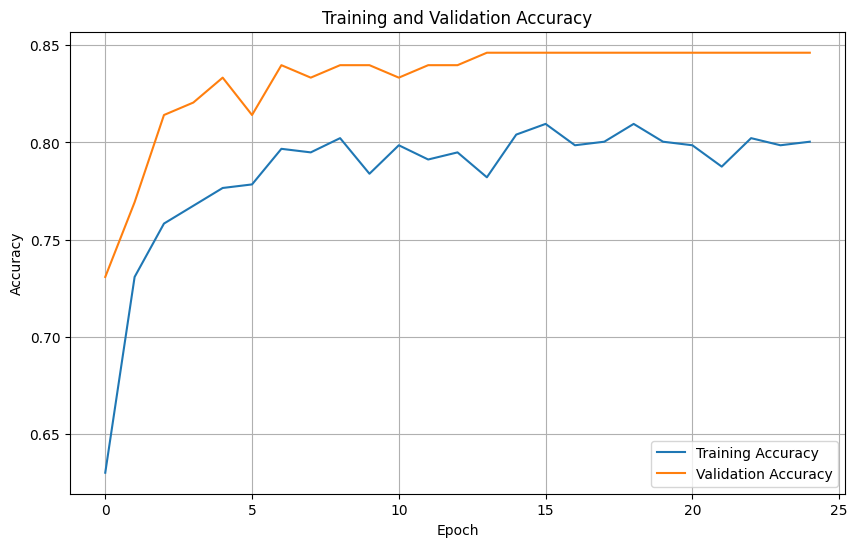

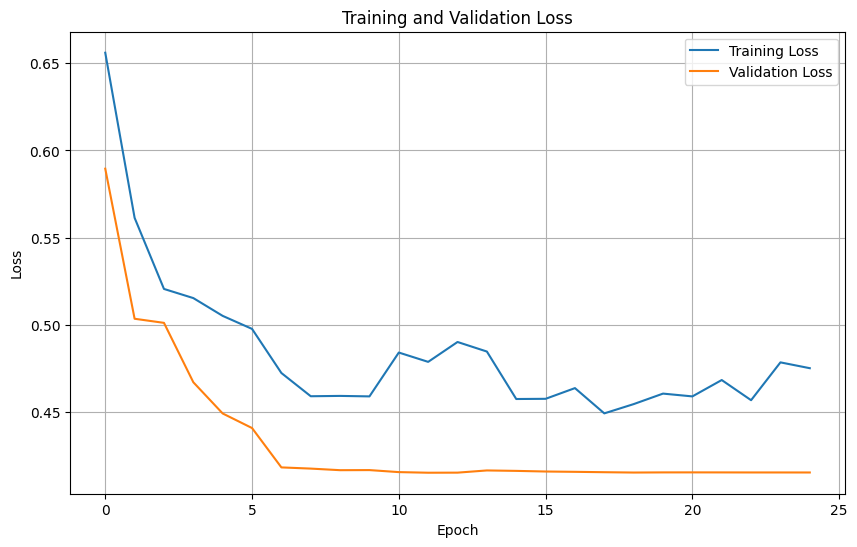

In [15]:
preTrainImageNet("squeezenet", dataset_name) #breastmnist (128x128)

Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Epoch 0/24
----------
train Loss: 0.5854 Acc: 0.7070
test Loss: 0.5430 Acc: 0.7308

Epoch 1/24
----------
train Loss: 0.5576 Acc: 0.7234
test Loss: 0.5069 Acc: 0.8013

Epoch 2/24
----------
train Loss: 0.5206 Acc: 0.7546
test Loss: 0.4941 Acc: 0.7692

Epoch 3/24
----------
train Loss: 0.5007 Acc: 0.7802
test Loss: 0.4960 Acc: 0.7885

Epoch 4/24
----------
train Loss: 0.4971 Acc: 0.7784
test Loss: 0.4823 Acc: 0.7821

Epoch 5/24
----------
train Loss: 0.4803 Acc: 0.7912
test Loss: 0.4377 Acc: 0.8526

Epoch 6/24
----------
train Loss: 0.4781 Acc: 0.7912
test Loss: 0.4285 Acc: 0.8526

Epoch 7/24
----------
train Loss: 0.4792 Acc: 0.8040
test Loss: 0.4262 Acc: 0.8590

Epoch 8/24
----------
train Loss: 0.4546 Acc: 0.8114
test Loss: 0.4251 Acc: 0.8590

Epoch 9/24
----------
train Loss: 0.4577 Acc: 0.8004
test Loss: 0.4236 Acc: 0.8590

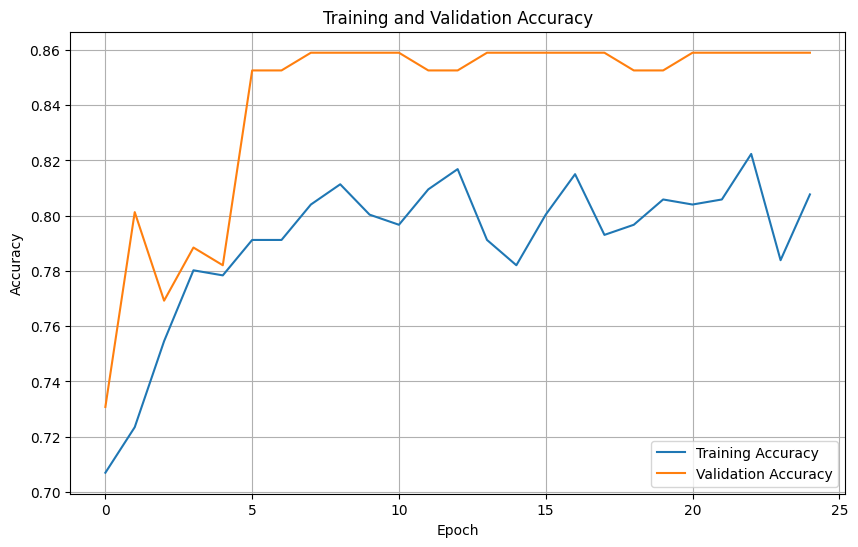

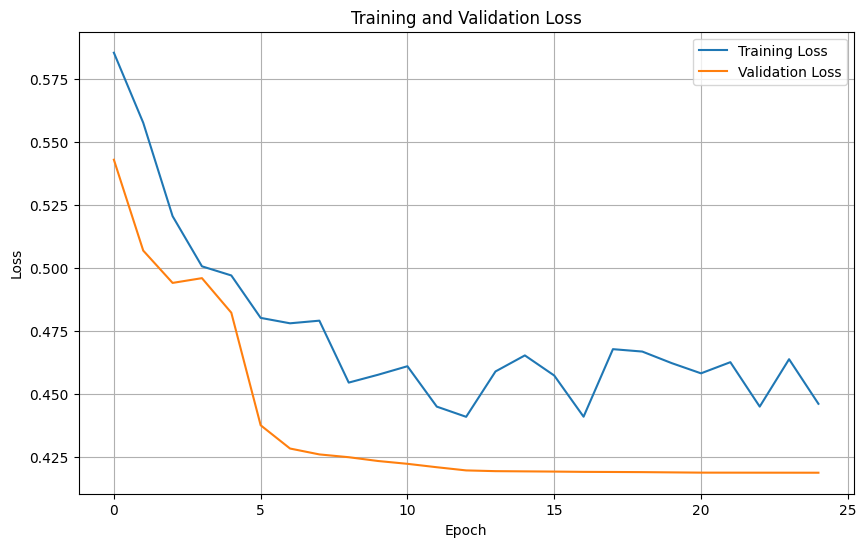

In [45]:
preTrainImageNet("squeezenet") #breastmnist (128x128)

## PneumoniaMNIST (128x128)

{'0': 'normal', '1': 'pneumonia'}
Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Epoch 0/9
----------
train Loss: 0.6605 Acc: 0.7421
test Loss: 0.6694 Acc: 0.6250

Epoch 1/9
----------
train Loss: 0.6270 Acc: 0.7421
test Loss: 0.6598 Acc: 0.6250

Epoch 2/9
----------
train Loss: 0.6061 Acc: 0.7421
test Loss: 0.6572 Acc: 0.6250

Epoch 3/9
----------
train Loss: 0.5925 Acc: 0.7421
test Loss: 0.6573 Acc: 0.6250

Epoch 4/9
----------
train Loss: 0.5835 Acc: 0.7421
test Loss: 0.6583 Acc: 0.6250

Epoch 5/9
----------
train Loss: 0.5778 Acc: 0.7421
test Loss: 0.6602 Acc: 0.6250

Epoch 6/9
----------
train Loss: 0.5735 Acc: 0.7421
test Loss: 0.6616 Acc: 0.6250

Epoch 7/9
----------
train Loss: 0.5713 Acc: 0.7421
test Loss: 0.6618 Acc: 0.6250

Epoch 8/9
----------
train Loss: 0.5710 Acc: 0.7421
test Loss: 0.6619 Acc: 0.6250

Epoch 9/9
----------
train Loss: 0.5706 Acc: 0.7421

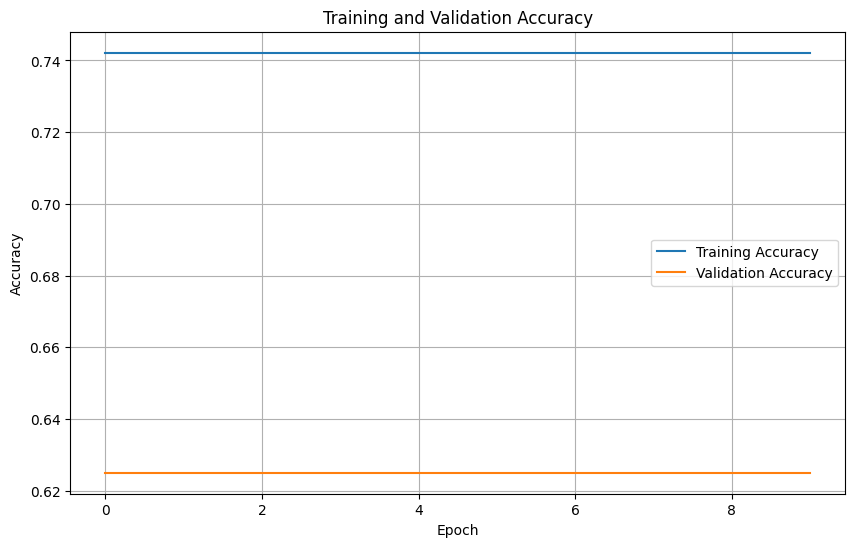

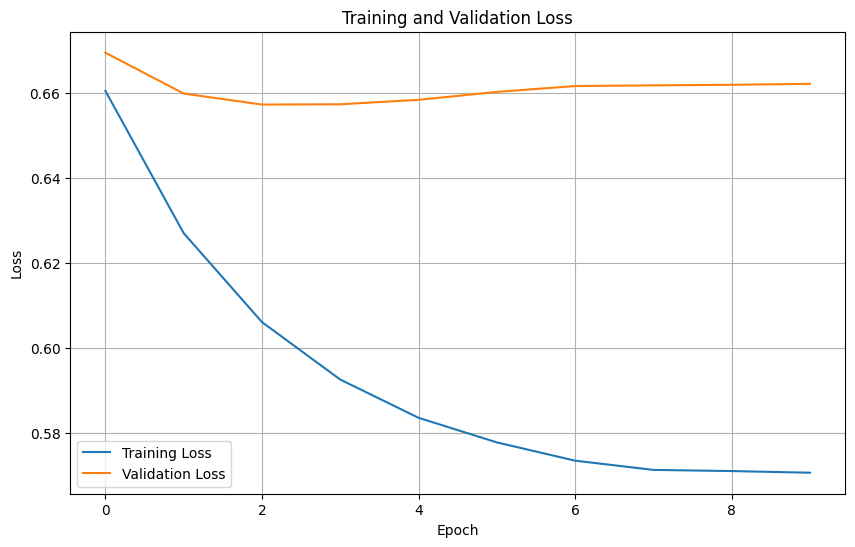

In [10]:
preTrainImageNet("shufflenet", 'pneumoniamnist')

{'0': 'normal', '1': 'pneumonia'}
Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Epoch 0/9
----------
train Loss: 0.5177 Acc: 0.7625
test Loss: 0.6215 Acc: 0.6282

Epoch 1/9
----------
train Loss: 0.4082 Acc: 0.8141
test Loss: 0.4773 Acc: 0.7532

Epoch 2/9
----------
train Loss: 0.3761 Acc: 0.8333
test Loss: 0.4706 Acc: 0.7644

Epoch 3/9
----------
train Loss: 0.3576 Acc: 0.8415
test Loss: 0.4566 Acc: 0.7788

Epoch 4/9
----------
train Loss: 0.3508 Acc: 0.8441
test Loss: 0.4333 Acc: 0.8045

Epoch 5/9
----------
train Loss: 0.3363 Acc: 0.8543
test Loss: 0.4392 Acc: 0.8013

Epoch 6/9
----------
train Loss: 0.3304 Acc: 0.8528
test Loss: 0.4665 Acc: 0.7692

Epoch 7/9
----------
train Loss: 0.3289 Acc: 0.8520
test Loss: 0.4309 Acc: 0.7981

Epoch 8/9
----------
train Loss: 0.3205 Acc: 0.8556
test Loss: 0.4243 Acc: 0.8077

Epoch 9/9
----------
train Loss: 0.3274 Acc: 0.8579

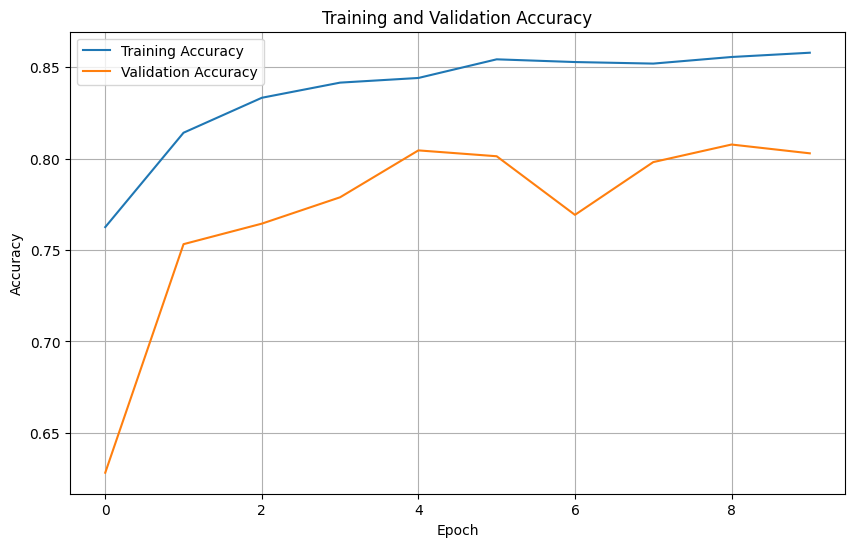

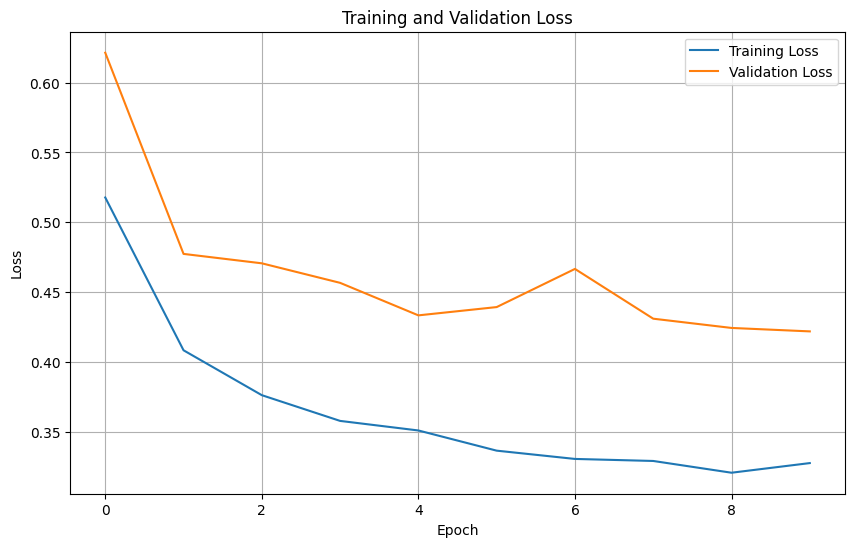

In [9]:
preTrainImageNet("squeezenext", 'pneumoniamnist')

Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Epoch 0/24
----------
train Loss: 0.3748 Acc: 0.8290
test Loss: 0.3145 Acc: 0.8718

Epoch 1/24
----------
train Loss: 0.3130 Acc: 0.8598
test Loss: 0.2568 Acc: 0.8958

Epoch 2/24
----------
train Loss: 0.2742 Acc: 0.8800
test Loss: 0.2449 Acc: 0.9022

Epoch 3/24
----------
train Loss: 0.2717 Acc: 0.8868
test Loss: 0.2608 Acc: 0.8894

Epoch 4/24
----------
train Loss: 0.2514 Acc: 0.8917
test Loss: 0.2294 Acc: 0.9038

Epoch 5/24
----------
train Loss: 0.2561 Acc: 0.8859
test Loss: 0.3507 Acc: 0.8574

Epoch 6/24
----------
train Loss: 0.2496 Acc: 0.8866
test Loss: 0.2728 Acc: 0.8798

Epoch 7/24
----------
train Loss: 0.2297 Acc: 0.9065
test Loss: 0.2345 Acc: 0.8974

Epoch 8/24
----------
train Loss: 0.2332 Acc: 0.9012
test Loss: 0.2362 Acc: 0.8990

Epoch 9/24
----------
train Loss: 0.2316 Acc: 0.9006
test Loss: 0.2315 Acc: 

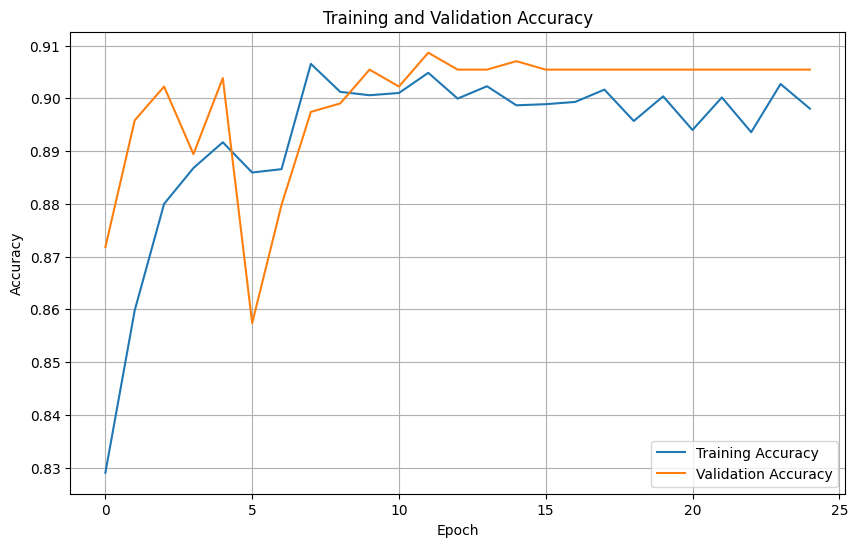

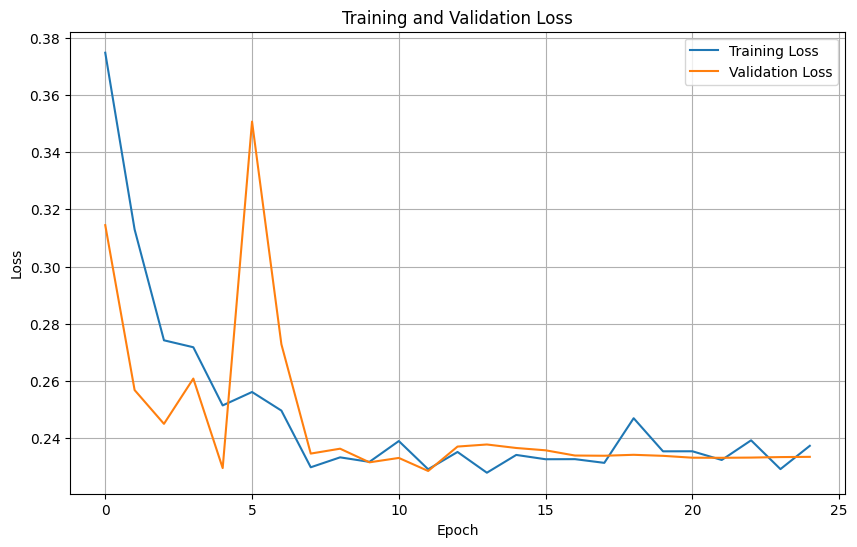

In [52]:
preTrainImageNet("squeezenet") #pneumoniamnist (128x128)

## DermaMNIST (128x128)

100%|█████████████████████████| 372579947/372579947 [06:39<00:00, 933461.25it/s]


Using downloaded and verified file: /home/anas/.medmnist/dermamnist_128.npz


/home/anas/anaconda3/envs/pylinenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anas/anaconda3/envs/pylinenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/home/anas/anaconda3/envs/pylinenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


train Loss: 1.0260 Acc: 0.6592
test Loss: 0.9504 Acc: 0.6823

Epoch 1/24
----------
train Loss: 0.8583 Acc: 0.6952
test Loss: 0.9572 Acc: 0.6638

Epoch 2/24
----------
train Loss: 0.8238 Acc: 0.6994
test Loss: 0.7856 Acc: 0.7132

Epoch 3/24
----------
train Loss: 0.7943 Acc: 0.7136
test Loss: 0.8822 Acc: 0.6708

Epoch 4/24
----------
train Loss: 0.7858 Acc: 0.7173
test Loss: 0.7662 Acc: 0.7187

Epoch 5/24
----------
train Loss: 0.7570 Acc: 0.7224
test Loss: 0.7670 Acc: 0.7267

Epoch 6/24
----------
train Loss: 0.7665 Acc: 0.7228
test Loss: 0.7253 Acc: 0.7337

Epoch 7/24
----------
train Loss: 0.7321 Acc: 0.7314
test Loss: 0.7287 Acc: 0.7327

Epoch 8/24
----------
train Loss: 0.7290 Acc: 0.7318
test Loss: 0.7225 Acc: 0.7362

Epoch 9/24
----------
train Loss: 0.7240 Acc: 0.7357
test Loss: 0.7140 Acc: 0.7411

Epoch 10/24
----------
train Loss: 0.7144 Acc: 0.7374
test Loss: 0.7123 Acc: 0.7367

Epoch 11/24
----------
train Loss: 0.7323 Acc: 0.7297
test Loss: 0.7113 Acc: 0.7406

Epoch 12/24


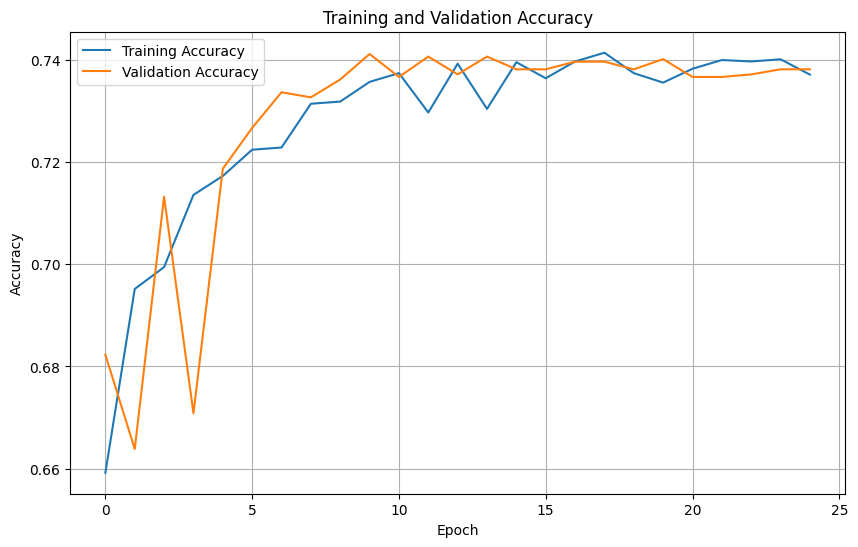

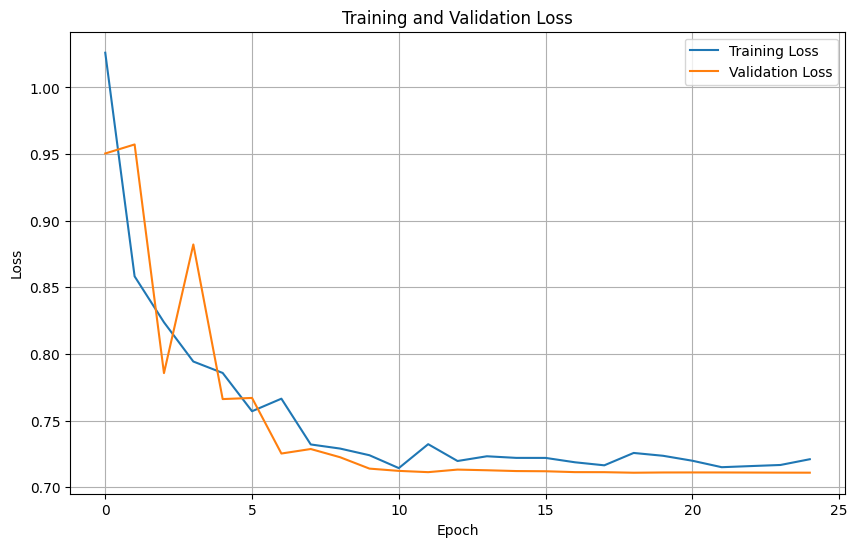

In [10]:
preTrainImageNet("squeezenet") #dermamnist (128x128)

## BloodMNIST (128x128)

{'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Using downloaded and verified file: /home/anas/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /home/anas/.medmnist/bloodmnist_128.npz
Epoch 0/9
----------


/home/anas/anaconda3/envs/pylinenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


train Loss: 1.2488 Acc: 0.5804
test Loss: 0.6540 Acc: 0.7600

Epoch 1/9
----------
train Loss: 0.7275 Acc: 0.7501
test Loss: 1.0936 Acc: 0.7562

Epoch 2/9
----------
train Loss: 0.6075 Acc: 0.7985
test Loss: 0.5724 Acc: 0.8103

Epoch 3/9
----------
train Loss: 0.5449 Acc: 0.8155
test Loss: 0.3311 Acc: 0.8910

Epoch 4/9
----------
train Loss: 0.5020 Acc: 0.8300
test Loss: 0.2888 Acc: 0.9135

Epoch 5/9
----------
train Loss: 0.4939 Acc: 0.8285
test Loss: 0.4427 Acc: 0.8404

Epoch 6/9
----------
train Loss: 0.4767 Acc: 0.8374
test Loss: 0.2892 Acc: 0.9111

Epoch 7/9
----------
train Loss: 0.4219 Acc: 0.8601
test Loss: 0.2475 Acc: 0.9246

Epoch 8/9
----------
train Loss: 0.4219 Acc: 0.8609
test Loss: 0.2471 Acc: 0.9255

Epoch 9/9
----------
train Loss: 0.4098 Acc: 0.8644
test Loss: 0.2440 Acc: 0.9275

Training complete in 4m 33s
Best val Acc: 0.927507
Accuracy: 0.8412
Precision: 0.8321
Recall: 0.8198
F1: 0.8251
Confusion Matrix: 
tensor([[ 68,   1,   0,  20,   6,   1,   0,   1],
        [ 

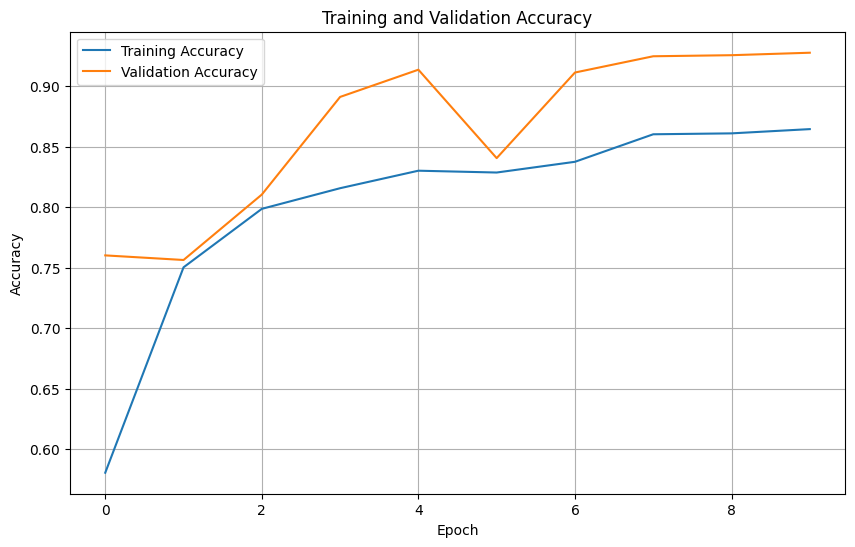

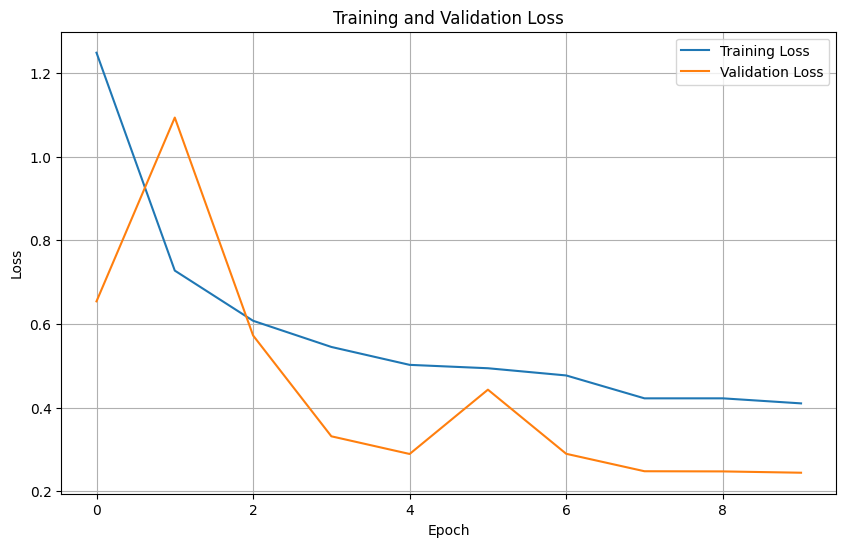

In [10]:
preTrainImageNet("squeezenet", dataset_name="bloodmnist")

{'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
Using downloaded and verified file: /home/anas/.medmnist/octmnist_128.npz
Using downloaded and verified file: /home/anas/.medmnist/octmnist_128.npz
Epoch 0/9
----------
train Loss: 0.5753 Acc: 0.7963
test Loss: 0.7879 Acc: 0.6490

Epoch 1/9
----------
train Loss: 0.4710 Acc: 0.8313
test Loss: 0.6952 Acc: 0.6950

Epoch 2/9
----------
train Loss: 0.4549 Acc: 0.8378
test Loss: 0.6529 Acc: 0.7150

Epoch 3/9
----------
train Loss: 0.4427 Acc: 0.8420
test Loss: 0.8311 Acc: 0.6400

Epoch 4/9
----------
train Loss: 0.4380 Acc: 0.8438
test Loss: 0.6815 Acc: 0.6930

Epoch 5/9
----------
train Loss: 0.4310 Acc: 0.8459
test Loss: 0.7908 Acc: 0.6490

Epoch 6/9
----------
train Loss: 0.4268 Acc: 0.8482
test Loss: 0.6397 Acc: 0.7150

Epoch 7/9
----------
train Loss: 0.4228 Acc: 0.8495
test Loss: 0.6843 Acc: 0.6930

Epoch 8/9
----------
train Loss: 0.4220 Acc: 0.8504
test Loss: 0.6962 Acc: 0.6890

Epoch 

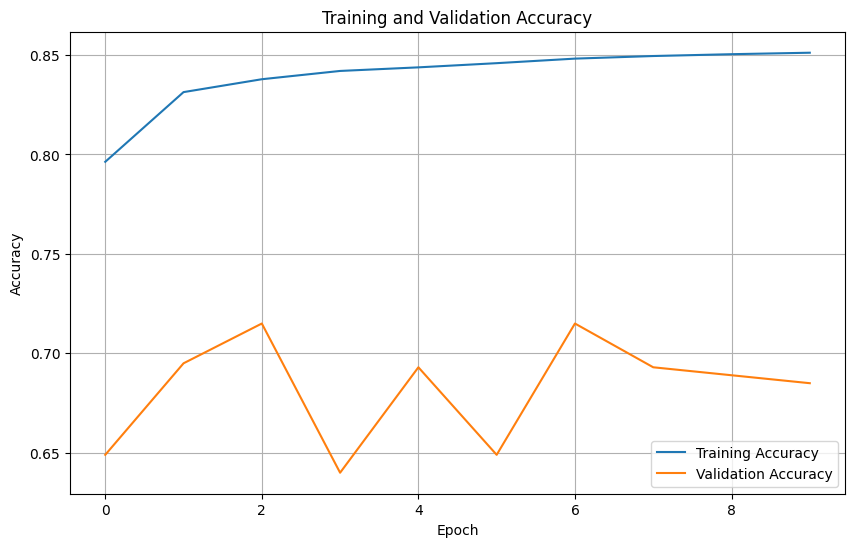

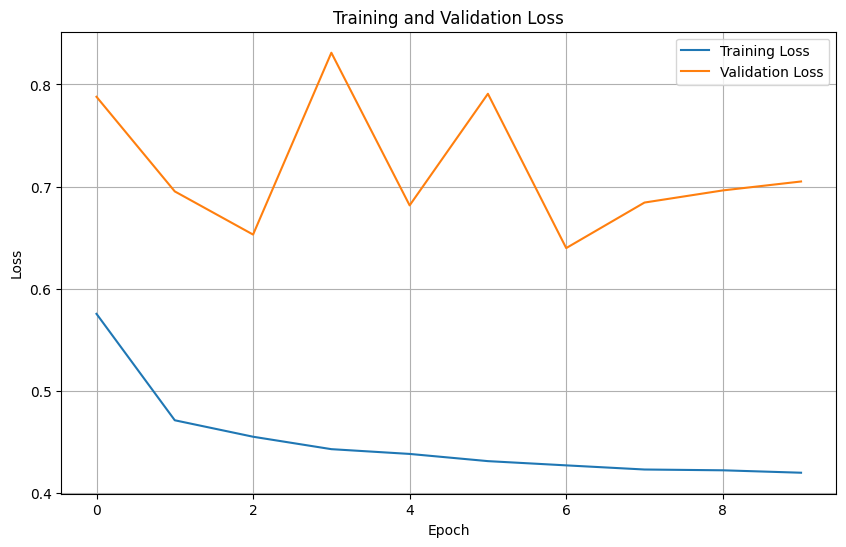

In [16]:
preTrainImageNet("squeezenet", dataset_name="octmnist")

## THB dataset

In [8]:
folder_path = 'THB_dataset'
classes = os.listdir(folder_path)
print(classes)

['Bluetooth', 'Humidity', 'Transistor']


In [7]:
def preTrainImageNet(model_name, classes):
  data_transforms = get_transforms()
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      folder_path = './THB_dataset'
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
    train_FileNames = [all_filenames[idx] for idx in train_idx]
    val_FileNames = [all_filenames[idx] for idx in test_idx]
    print('Fold: ',i)
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    fold_dir = f'./splitted_dataset/fold{i}'
    if not os.path.exists(fold_dir):
        os.makedirs(fold_dir+'/train')
        os.makedirs(fold_dir+'/val')

        # Creating the class folders in train and validation folders
        for class_name in classes:
            os.makedirs(fold_dir+'/train/' + class_name)
            os.makedirs(fold_dir+'/val/' + class_name)
    
        for name in train_FileNames:
            name_split = name.split('\\')
            class_name = name_split[1] + '/' + name_split[2]
            shutil.copy(name, fold_dir+'/train/' + class_name)
        for name in val_FileNames:
            name_split = name.split('\\')
            class_name = name_split[1] + '/' + name_split[2]
            shutil.copy(name, fold_dir+'/val/' + class_name)


    sets = ['train','val']
    image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                            data_transforms[x])
                    for x in ['train','val']}
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                shuffle=True,num_workers=0)
                    for x in ['train','val']}

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


    pretrained_model_ImageNet = models.squeezenet1_1(pretrained=True)

    #freezing previous layers
    for param in pretrained_model_ImageNet.features.parameters():
        param.requires_grad = False

    #exchange the last layer
    num_classes = 3

    if model_name in ['googlenet', 'resnet18']:
        pretrained_model_ImageNet.fc = nn.Linear(in_features=pretrained_model_ImageNet.fc.in_features, out_features=num_classes, device=device)
    elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_ImageNet.classifier[6].in_features
        pretrained_model_ImageNet.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'squeezenet':
        # Newly created modules have require_grad=True by default
        num_features = pretrained_model_ImageNet.classifier[1].in_channels
        features = list(pretrained_model_ImageNet.classifier.children())[:-3] # Remove last 3 layers
        features.extend([nn.Conv2d(num_features, num_classes, kernel_size=1)]) # Add
        features.extend([nn.ReLU(inplace=True)]) # Add
        features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
        pretrained_model_ImageNet.classifier = nn.Sequential(*features)

    elif model_name == 'inceptionv3':
        num_ftrs = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(num_ftrs, 3)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")

    pretrained_model_ImageNet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.001)

    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

    model_ft, metrics = train_model(pretrained_model_ImageNet, criterion, optimizer, step_lr_scheduler, dataloaders, dataset_sizes, i, num_epochs=25)

    all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)
  # print_performance()

Fold:  0
Training:  262
Validation:  66


C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.8415 Acc: 0.6145
val Loss: 0.5274 Acc: 0.7576

Epoch 1/24
----------
train Loss: 0.4918 Acc: 0.8282
val Loss: 0.2886 Acc: 0.9242

Epoch 2/24
----------
train Loss: 0.3423 Acc: 0.8969
val Loss: 0.1671 Acc: 0.9697

Epoch 3/24
----------
train Loss: 0.2359 Acc: 0.9084
val Loss: 0.1380 Acc: 0.9545

Epoch 4/24
----------
train Loss: 0.2217 Acc: 0.9313
val Loss: 0.0936 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1742 Acc: 0.9466
val Loss: 0.0707 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1480 Acc: 0.9656
val Loss: 0.0700 Acc: 0.9697

Epoch 7/24
----------
train Loss: 0.1416 Acc: 0.9618
val Loss: 0.0615 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.1455 Acc: 0.9580
val Loss: 0.0652 Acc: 0.9697

Epoch 9/24
----------
train Loss: 0.1593 Acc: 0.9580
val Loss: 0.0594 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.1435 Acc: 0.9504
val Loss: 0.0566 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.1290 Acc: 0.9656
val Loss: 0.0541 Acc: 0.9848

Ep

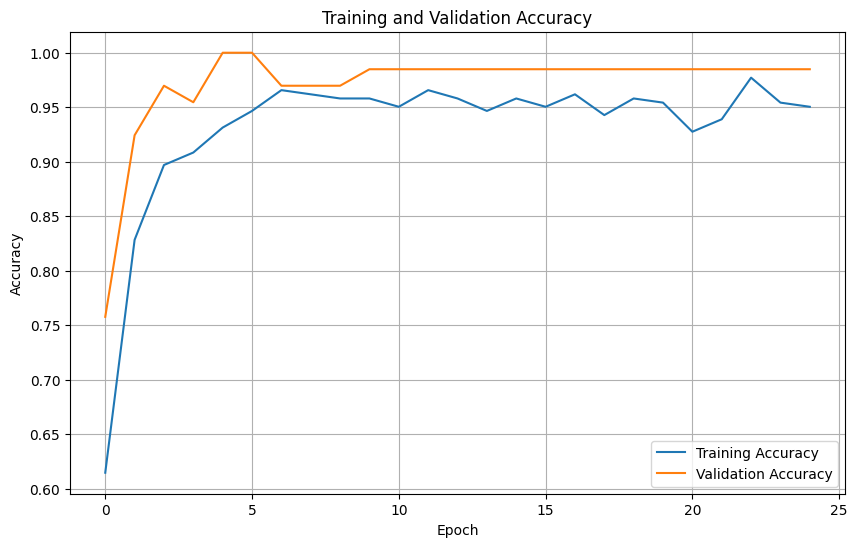

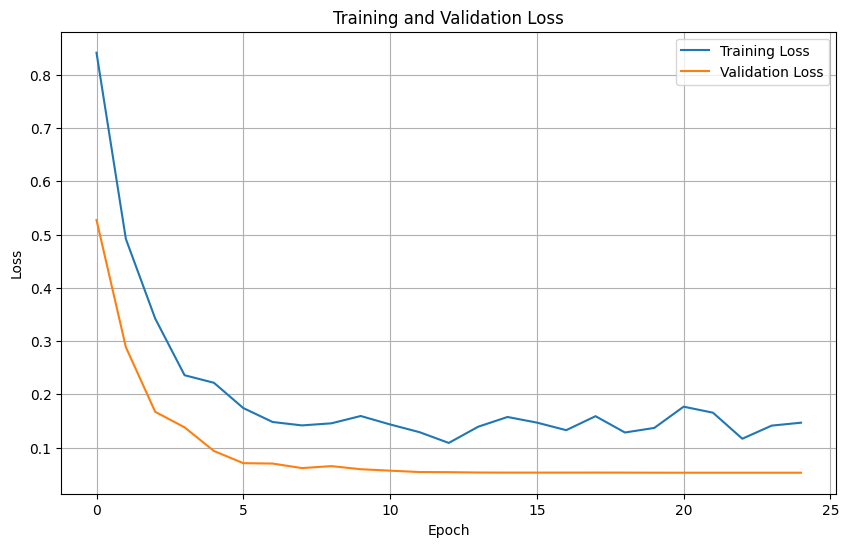

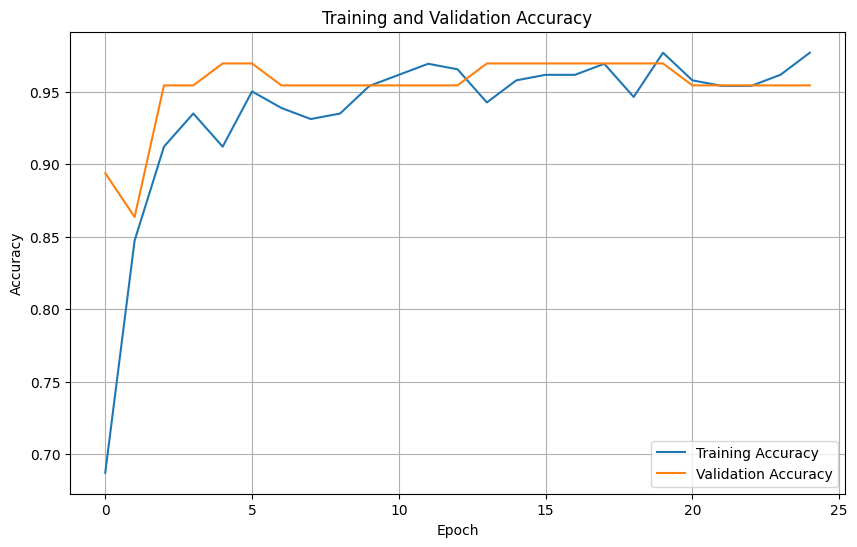

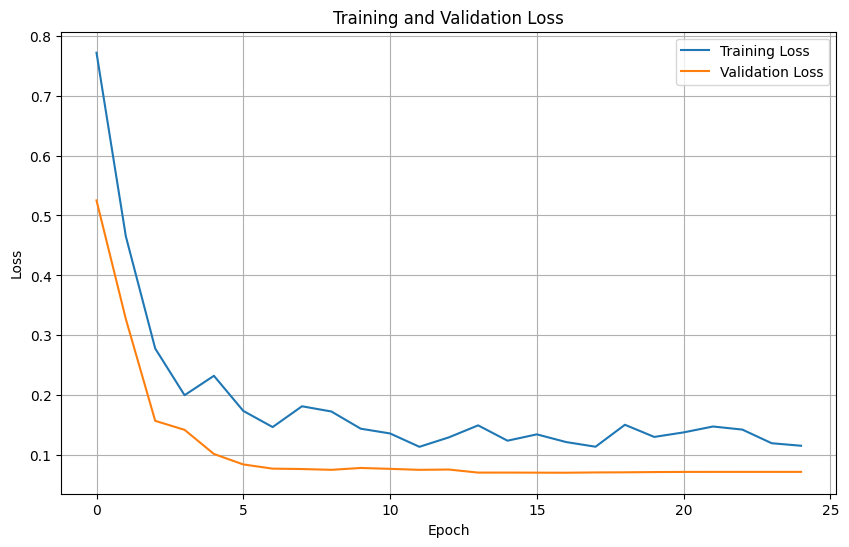

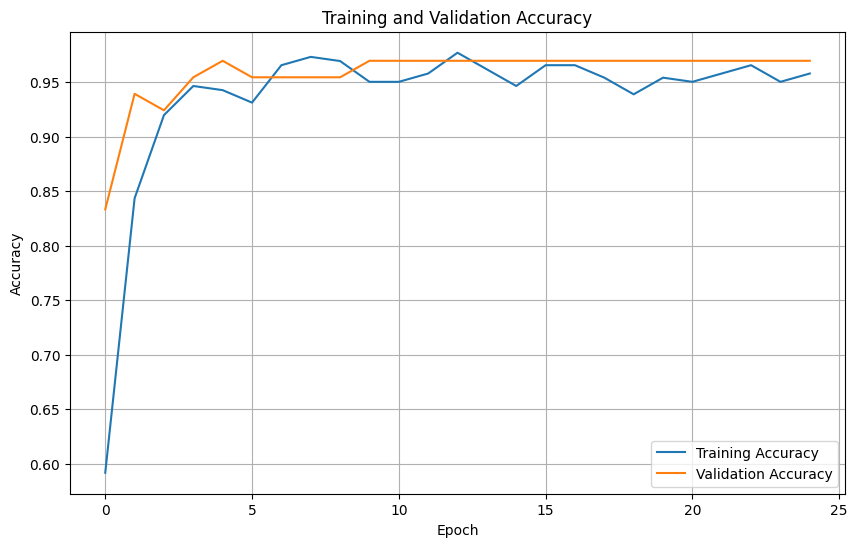

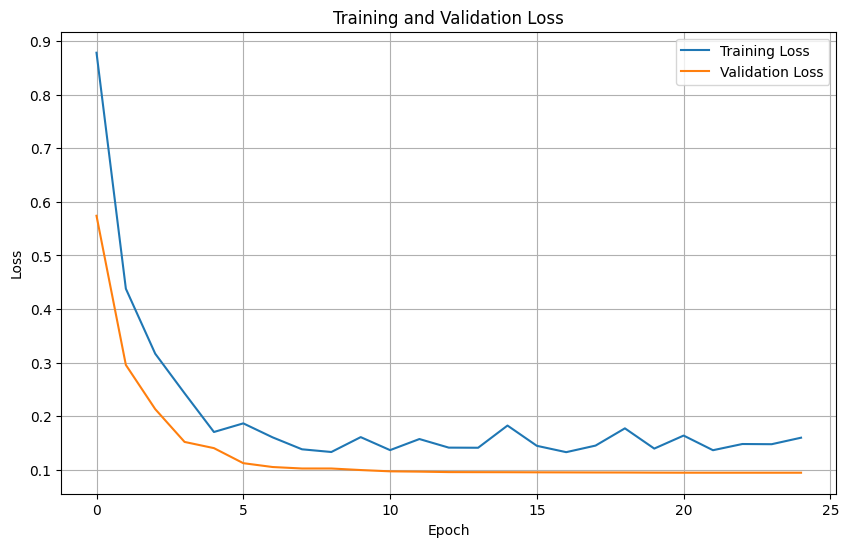

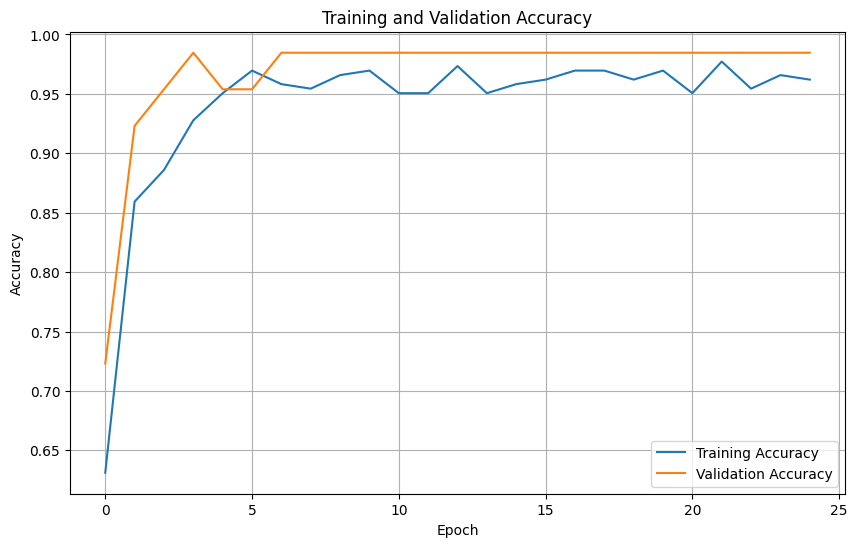

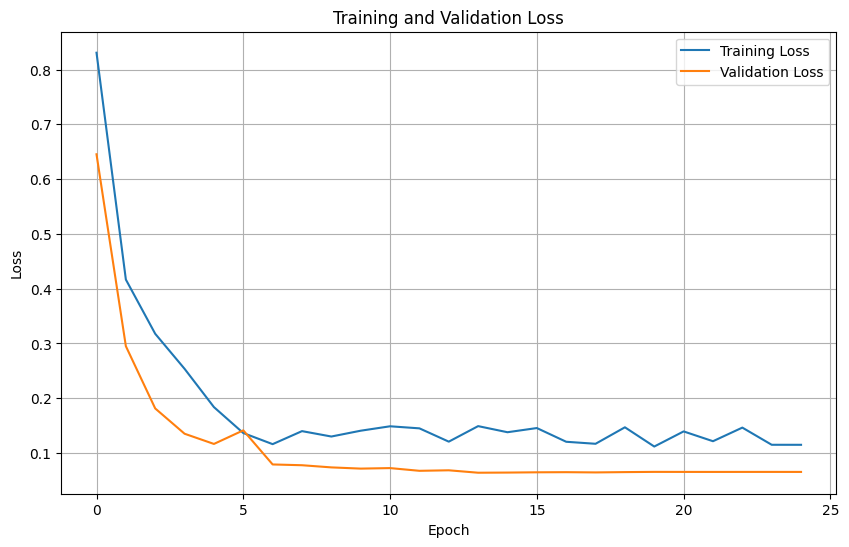

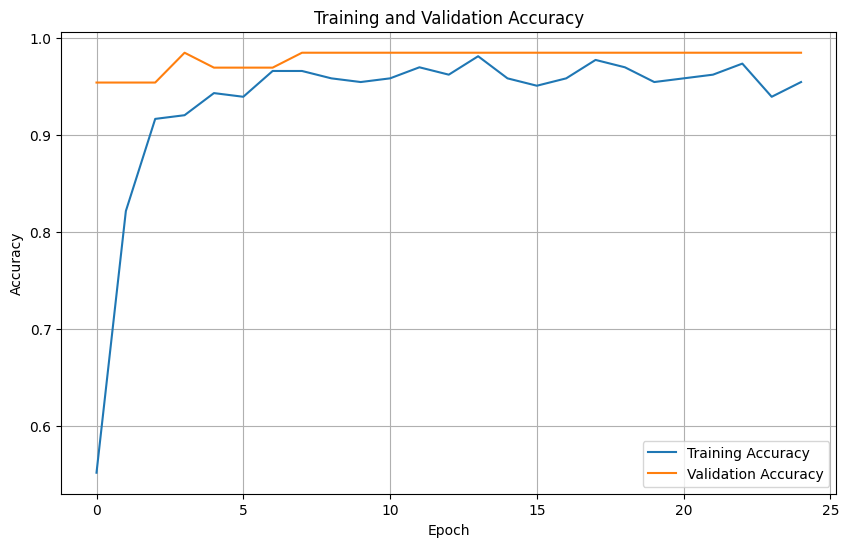

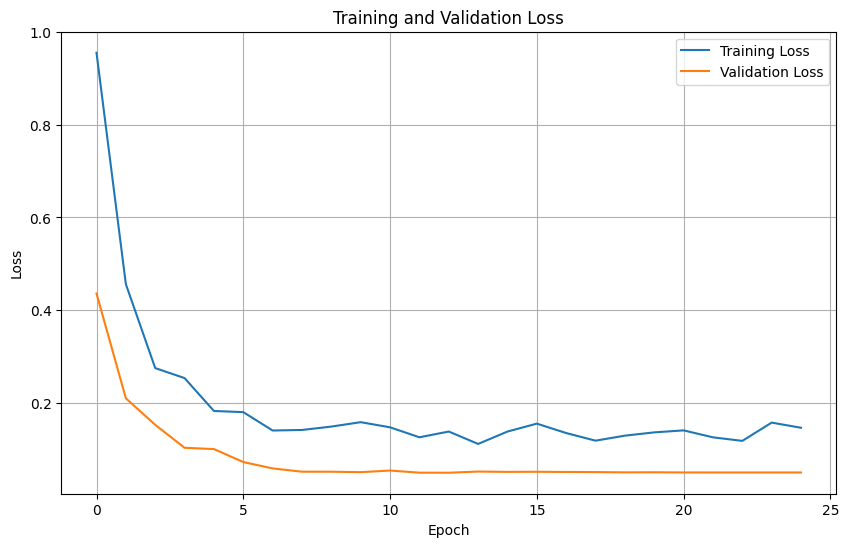

In [9]:
preTrainImageNet("squeezenet",classes) #THB dataset